<a href="https://colab.research.google.com/github/meucham11/Dacon/blob/master/dacon_temp_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

데이터 설명

-     대전지역에서 측정한 실내외 19곳의 센서데이터와, 주변 지역의 기상청 공공데이터를 semi-비식별화하여 제공합니다.

-     센서는 온도를 측정하였습니다.

-     모든 데이터는 시간 순으로 정렬 되어 있으며 10분 단위 데이터 입니다.

-     예측 대상(target variable)은 Y18입니다.



train.csv 

-     30일 간의 기상청 데이터 (X00~X39) 및 센서데이터 (Y00~Y17)

-     이후 3일 간의 기상청 데이터 (X00~X39) 및 센서데이터 (Y18)



test.csv 

-     train.csv 기간 이후 80일 간의 기상청 데이터 (X00~X39)



sample_submission.csv

-     제출 양식 예시

In [ ]:
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/drive', force_remount=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
from pathlib import Path

# folder 변수에 구글드라이브에 프로젝트를 저장한 디렉토리를 입력하세요!
# My Drive 밑에 저장했다면 그대로 두시면 됩니다.
folder = "AIFrenz_Season1_dataset"
project_dir = ""

base_path = Path("/content/drive/My Drive/")
project_path = base_path / folder / project_dir
os.chdir(project_path)
for x in list(project_path.glob("*")):
    if x.is_dir():
        dir_name = str(x.relative_to(project_path))
        os.rename(dir_name, dir_name.split(" ", 1)[0])
print(f"현재 디렉토리 위치: {os.getcwd()}")

현재 디렉토리 위치: /content/drive/My Drive/AIFrenz_Season1_dataset


In [ ]:
#!pip install tensorflow-gpu==2.0.0

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals


from IPython.display import clear_output

import os
import time
import glob
import csv
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

print('tensorflow version: {}'.format(tf.__version__))
print('GPU 사용 가능 여부: {}'.format(tf.test.is_gpu_available()))

tensorflow version: 2.0.0
GPU 사용 가능 여부: False


In [ ]:
raw_train_data = pd.read_csv('./train.csv')
raw_test_data = pd.read_csv('./test.csv')
submission_data = pd.read_csv('./sample_submission.csv')

In [ ]:
raw_train_data=raw_train_data.iloc[0:4320]
train_label = raw_train_data['Y05']
raw_train_data=raw_train_data.drop(raw_train_data.columns[range(41,len(raw_train_data.columns))],axis='columns')
del raw_train_data['id']

train_data, val_data,train_label, val_label=train_test_split(raw_train_data, train_label, test_size=0.2)

In [ ]:
train_data=train_data.sort_index().reset_index(drop=True)
train_label=train_label.sort_index().reset_index(drop=True)
val_data=val_data.sort_index().reset_index(drop=True)
val_label=val_label.sort_index().reset_index(drop=True)

In [ ]:
train_data=train_data.to_numpy()
train_label=train_label.to_numpy()
val_data=val_data.to_numpy()
val_label=val_label.to_numpy()
del raw_test_data['id']
test_data=raw_test_data.to_numpy()

In [ ]:
train_data = train_data.astype(np.float32)
train_label = train_label.astype(np.float32)
val_data = val_data.astype(np.float32)
val_label = val_label.astype(np.float32)

test_data = test_data.astype(np.float32)

# dataset

In [ ]:
def make_dataset(data,tar, seq_length=432, target_delay=1, strides=4):
    min_max_scaler = MinMaxScaler()
    data = min_max_scaler.fit_transform(data)

    min_max_scaler = MinMaxScaler()
    
    tar = min_max_scaler.fit_transform(tar.reshape(-1,1))
    
    

    sequence = []
    target = []
    for index in range(len(data) - seq_length - target_delay):
        if index % strides == 0:  
            sequence.append(data[index:index+seq_length])    # 위의 설명 2-1 을 참고하여 None을 채우세요.
            target.append(tar[index+seq_length+target_delay])
    
    return np.array(sequence), np.array(target), min_max_scaler


In [ ]:
train_sequences, train_labels, train_scaler= make_dataset(data=train_data,tar=train_label)
val_sequences,val_labels,  var_scaler = make_dataset(val_data,val_label)

# hyperparameter

In [ ]:
batch_size = 128
max_epochs = 20
learning_rate = 3e-5
hidden_sizes = [100,100] # hidden_sizes must be a list

In [ ]:
N = BUFFER_SIZE = len(train_sequences)
train_dataset = tf.data.Dataset.from_tensor_slices((train_sequences, train_labels))
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.repeat()

In [ ]:
val_dataset = tf.data.Dataset.from_tensor_slices((val_sequences, val_labels))
val_dataset = val_dataset.batch(batch_size)
val_dataset = val_dataset.repeat()

In [ ]:
model = tf.keras.Sequential()

In [ ]:
num_layers = len(hidden_sizes)
for i in range(num_layers - 1):
    
    ## 코드 시작 ##
    model.add(tf.keras.layers.LSTM(100,input_shape=(None,40),return_sequences=True))
    model.add(tf.keras.layers.LSTM(100,return_sequences = False))
    model.add(tf.keras.layers.Dense(1))
    ## 코드 종료 ##


In [ ]:
for step, (sequences, targets) in enumerate(train_dataset.take(1)):
    predictions = model(sequences)

In [ ]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, None, 100)         56400     
_________________________________________________________________
lstm_15 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 101       
Total params: 136,901
Trainable params: 136,901
Non-trainable params: 0
_________________________________________________________________


In [ ]:
## 코드 시작 ##
model.compile(loss=tf.keras.losses.MeanSquaredError(), 
              optimizer=tf.optimizers.Adam(learning_rate=learning_rate), 
              metrics=['mse'])
## 코드 종료 ##

In [ ]:
train_dataset

<RepeatDataset shapes: ((None, 432, 40), (None, 1)), types: (tf.float32, tf.float32)>

In [ ]:
model.fit(train_dataset, steps_per_epoch = (len(train_data)/batch_size), 
          validation_data = val_dataset, 
          validation_steps= len(val_data)/batch_size,
          epochs= max_epochs,
)

Train for 27.0 steps, validate for 6.75 steps
Epoch 1/20
27/27 [==============================] - 76s 3s/step - loss: 0.1125 - mse: 0.1125 - val_loss: 0.0349 - val_mse: 0.0336
Epoch 2/20
27/27 [==============================] - 72s 3s/step - loss: 0.0454 - mse: 0.0454 - val_loss: 0.0345 - val_mse: 0.0333
Epoch 3/20
27/27 [==============================] - 73s 3s/step - loss: 0.0302 - mse: 0.0303 - val_loss: 0.0367 - val_mse: 0.0353
Epoch 4/20
27/27 [==============================] - 74s 3s/step - loss: 0.0236 - mse: 0.0236 - val_loss: 0.0381 - val_mse: 0.0368
Epoch 5/20
27/27 [==============================] - 75s 3s/step - loss: 0.0183 - mse: 0.0183 - val_loss: 0.0391 - val_mse: 0.0377
Epoch 6/20
27/27 [==============================] - 74s 3s/step - loss: 0.0144 - mse: 0.0144 - val_loss: 0.0400 - val_mse: 0.0386
Epoch 7/20
27/27 [==============================] - 73s 3s/step - loss: 0.0114 - mse: 0.0114 - val_loss: 0.0413 - val_mse: 0.0398
Epoch 8/20
27/27 [==========================

In [ ]:
----------------------------------------------------------------------

SyntaxError: ignored

In [ ]:
scaler = MinMaxScaler(feature_range = (0,1))
sc_test_data = scaler.fit_transform(test_data)

In [ ]:
sc_test_data


NameError: ignored

In [ ]:
sc_test_data.reshape(-1,1,40)

array([[[0.15384614, 0.6151085 , 0.13636364, ..., 0.81529576,
         0.5075239 , 0.        ]],

       [[0.1586538 , 0.6151085 , 0.1       , ..., 0.81529576,
         0.5157318 , 0.        ]],

       [[0.16826922, 0.6151085 , 0.11818182, ..., 0.8297258 ,
         0.51983577, 0.        ]],

       ...,

       [[0.48557693, 0.8237419 , 0.34545454, ..., 0.7460317 ,
         0.62243503, 0.00628931]],

       [[0.48076922, 0.8237419 , 0.21818183, ..., 0.7590187 ,
         0.62927496, 0.00628931]],

       [[0.4759615 , 0.8237419 , 0.27272728, ..., 0.7604616 ,
         0.63064295, 0.00628931]]], dtype=float32)

In [ ]:
pred=model.predict(sc_test_data.reshape(-1,1,40),batch_size=batch_size)


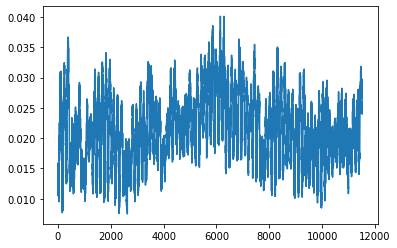

In [ ]:
plt.plot(pred)


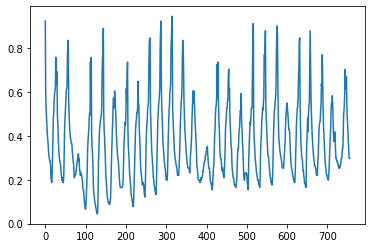

In [ ]:
plt.plot(train_labels)

In [ ]:
train_scaler.inverse_transform(pred.reshape(-1,1))

array([[49.5     ],
       [34.5     ],
       [31.5     ],
       [29.5     ],
       [27.      ],
       [26.      ],
       [25.      ],
       [24.      ],
       [22.499998],
       [21.499998],
       [20.999998],
       [20.499998],
       [20.499998],
       [19.499998],
       [17.      ],
       [16.5     ],
       [16.      ],
       [17.5     ],
       [21.499998],
       [25.5     ],
       [29.5     ],
       [30.5     ],
       [33.      ],
       [34.5     ],
       [35.      ],
       [35.5     ],
       [42.      ],
       [39.5     ],
       [36.5     ],
       [39.      ],
       [30.      ],
       [28.5     ],
       [25.5     ],
       [23.5     ],
       [21.999998],
       [20.999998],
       [20.499998],
       [19.999998],
       [19.499998],
       [18.5     ],
       [17.5     ],
       [16.5     ],
       [17.      ],
       [16.5     ],
       [16.      ],
       [16.      ],
       [18.      ],
       [22.499998],
       [27.5     ],
       [29.5     ],


53.0

In [ ]:
pred

array([8.121327, 8.101749, 8.175953, ..., 8.679057, 8.654987, 8.62977 ],
      dtype=float32)

In [ ]:
submission_data['Y18']=pred

In [ ]:
submission_data

,id,Y18
0,4752,8.121327
1,4753,8.101749
2,4754,8.175953
3,4755,8.100624
4,4756,8.126120
...,...,...
11515,16267,8.616138
11516,16268,8.666847
11517,16269,8.679057
11518,16270,8.654987


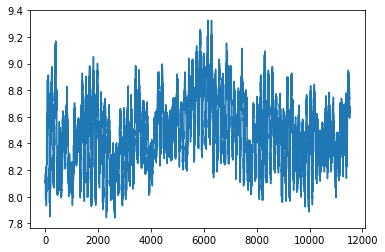

In [ ]:
plt.plot(pred)

array([[8.121327],
       [8.101749],
       [8.175953],
       ...,
       [8.679057],
       [8.654987],
       [8.62977 ]], dtype=float32)

In [ ]:
train_label

array([10.5, 10. , 10. , ..., 21. , 21. , 20.5], dtype=float32)

In [ ]:
zz= MinMaxScaler()
zzv=zz.fit_transform(train_label.reshape(-1,1))

In [ ]:
zzv

array([[0.06593406],
       [0.05494505],
       [0.05494505],
       ...,
       [0.29670328],
       [0.29670328],
       [0.28571427]], dtype=float32)

In [ ]:
zz.inverse_transform(zzv)

array([[10.5     ],
       [10.      ],
       [10.      ],
       ...,
       [20.999998],
       [20.999998],
       [20.499998]], dtype=float32)